<a href="https://colab.research.google.com/github/Francisroyce/Francisroyce/blob/main/Deep_learning_model_that_can_lip_read.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import Dependencies

In [255]:
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [256]:
# pip list

In [257]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio
from typing import List

In [258]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [259]:
 tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [260]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name:
    print("GPU device:", device_name)
else:
    print("CPU")


GPU device: /device:GPU:0


# Building Data Loading Functions

In [261]:
import gdown

In [262]:
# # downloading our data from an external google drive
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [263]:
# Creating a function to load videos
def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

This function, `load_video`, takes a path to a video file as input and returns a normalized representation of the video frames as a list of tensors.

Here's a breakdown of what the function does:

1. It imports the necessary libraries: `cv2` for video capture and `tensorflow` for image processing.
2. The function accepts a `path` parameter, which specifies the path to the video file to be loaded.
3. It initializes a video capture object `cap` using `cv2.VideoCapture(path)` to open the video file.
4. An empty list `frames` is created to store the processed video frames.
5. The function enters a loop that continues until there are no more frames to read (`cap.isOpened()`).
6. Within the loop, it reads each frame using `cap.read()`. The return value `ret` indicates whether the frame was successfully read.
7. If `ret` is `False`, it means there are no more frames to read, and the loop is terminated using `break`.
8. The current frame is converted to grayscale using `tf.image.rgb_to_grayscale(frame)`.
9. A specific region of interest (ROI) is extracted from the frame using indexing: `frame[190:236, 80:220, :]`. This ROI represents a rectangular portion of the frame defined by the specified coordinates.
10. The extracted ROI is appended to the `frames` list.
11. After all frames have been processed, the video capture object is released using `cap.release()` to free up system resources.
12. The list of frames is converted into a tensor using `tf.stack(frames)`. This results in a tensor with the shape `[num_frames, height, width, channels]`.
13. The mean value of the tensor is calculated using `tf.reduce_mean(frames)`.
14. The standard deviation of the tensor is calculated using `tf.math.reduce_std(frames)`.
15. The tensor is normalized by subtracting the mean and dividing by the standard deviation. This is achieved with `(frames - mean) / std`.
16. Finally, the normalized tensor is casted to `tf.float32` using `tf.cast(..., tf.float32)` and returned as the output of the function.

Overall, this function loads a video file, extracts specific regions of interest from each frame, calculates the mean and standard deviation of the frames, and returns the normalized frames as a tensor.

In [264]:
# vocabulary= words or letter we may encounter in data
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789"]
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [265]:
# converting characters to numbers and vice versa
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()}"
      f" (size = {char_to_num.vocabulary_size})")


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9'] (size = <bound method IndexLookup.vocabulary_size of <keras.layers.preprocessing.string_lookup.StringLookup object at 0x7fc07cb56560>>)


This code uses the TensorFlow library to define and initialize two layers for mapping characters to numbers and vice versa. Here's a breakdown of what each line does:

1. `char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")`: This line creates a `StringLookup` layer named `char_to_num`. It takes two arguments: `vocabulary` and `oov_token`. The `vocabulary` parameter is set to `vocab`, which represents a list or set of characters or words that the layer will use for mapping. The `oov_token` parameter specifies the out-of-vocabulary token, which is an empty string (`""`) in this case. The `StringLookup` layer is responsible for converting characters/strings to numerical indices.

2. `num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)`: This line creates another `StringLookup` layer named `num_to_char`. It uses the `get_vocabulary()` method of `char_to_num` to retrieve the vocabulary learned by the previous layer. By setting `invert=True`, this layer will map numerical indices back to the original characters/strings.

3. `print(f"The vocabulary is: {char_to_num.get_vocabulary()}" f" (size = {char_to_num.vocabulary_size})")`: This line prints the vocabulary learned by the `char_to_num` layer, as well as its size. It uses f-string formatting to include the values in the string output.

Overall, this code sets up two layers for converting characters to numbers and vice versa, and then prints the vocabulary learned by the first layer.

In [266]:
# you can see it is converted to numbers
char_to_num(['a', 'b', 'c', 'd'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>

In [267]:
# number to char
num_to_char([1, 2, 3, 4])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'b', b'c', b'd'], dtype=object)>

In [268]:
# Loading alignments function
def load_alignments(path: str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens.extend([' ', line[2]])
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


This code appears to load alignments from a file and convert them into a numerical representation. Let's break it down step by step:

1. The function `load_alignments` takes a parameter `path`, which is the path to the file containing alignments, and it returns a list of strings.

2. It opens the file specified by `path` using the `open()` function, in read mode ('r'), and assigns the file object to the variable `f`.

3. It reads all the lines from the file using the `readlines()` method of the file object `f`, and assigns the resulting list of lines to the variable `lines`.

4. It initializes an empty list called `tokens` to store the alignment tokens.

5. It iterates over each line in the `lines` list using a for loop.

6. Inside the loop, it splits the line into a list of words using the `split()` method, and assigns it to the variable `line`.

7. It checks if the third element (`line[2]`) of the `line` list is not equal to the string 'sil'.

8. If the condition is true, it appends the third element (`line[2]`) to the `tokens` list using the list concatenation operator `[*tokens, ' ', line[2]]`. The ' ' is added as a space separator between tokens.

9. Finally, it converts the `tokens` list into a numerical representation. It reshapes the list into a tensor using `tf.reshape()`, then splits the strings into Unicode characters using `tf.strings.unicode_split()`, and converts the characters into numerical values using `char_to_num()`.

10. The resulting numerical representation of the tokens is returned as the output of the function.

In [269]:
import os
# load data function
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('/content/drive/MyDrive/data/s1', f'{file_name}.mpg')
    alignment_path = os.path.join('/content/drive/MyDrive/data/alignments/s1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments


The function load_data takes a single argument path, which is expected to be a string.

The path argument is converted from a numpy array to a regular string using the bytes.decode() method.

The code then extracts the file name from the path string by splitting it using the backslash (\) as the delimiter. It takes the last element of the resulting list, which should be the file name, and removes the file extension by splitting it again using the dot (.) as the delimiter. It takes the first element of this new list, which should be the file name without the extension. The resulting file name is stored in the file_name variable.

The video_path variable is created by joining the strings 'data', 's1', and the file_name with the .mpg extension. This suggests that the code is constructing a file path to load a video file from a specific directory.

The alignment_path variable is created by joining the strings 'data', 'alignment', 's1', and the file_name with the .align extension. This suggests that the code is constructing a file path to load alignment data from a specific directory.

The code calls two unspecified functions, load_video() and load_alignments(), passing in the video_path and alignment_path respectively. These functions are expected to load video frames and alignment data, but their implementations are not shown in the provided code snippet.

The function returns the loaded frames and alignments as a tuple.

In [270]:
test_path = '/content/drive/MyDrive/data/s1/bbaf2n.mpg'

In [271]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbaf2n'

In [272]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[1.4991663 ],
          [1.4991663 ],
          [1.4616871 ],
          ...,
          [0.41227072],
          [0.41227072],
          [0.41227072]],
 
         [[1.4991663 ],
          [1.4991663 ],
          [1.4616871 ],
          ...,
          [0.41227072],
          [0.41227072],
          [0.41227072]],
 
         [[1.4616871 ],
          [1.4616871 ],
          [1.4991663 ],
          ...,
          [0.3373124 ],
          [0.3373124 ],
          [0.3373124 ]],
 
         ...,
 
         [[1.0494163 ],
          [1.0494163 ],
          [1.0119373 ],
          ...,
          [0.11243746],
          [0.11243746],
          [0.07495831]],
 
         [[1.0494163 ],
          [1.0494163 ],
          [1.0119373 ],
          ...,
          [0.11243746],
          [0.07495831],
          [0.07495831]],
 
         [[1.0494163 ],
          [1.0494163 ],
          [1.0119373 ],
          ...,
          [0.07495831],
    

In [273]:
frames , alignments = load_data(tf.convert_to_tensor(test_path))

In [274]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4616871 ],
         [1.4616871 ],
         [1.4991663 ],
         ...,
         [0.3373124 ],
         [0.3373124 ],
         [0.3373124 ]],

        ...,

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.11243746],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.07495831],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.07495831],
         [0.07495831],
         [0.03747915]]],


  

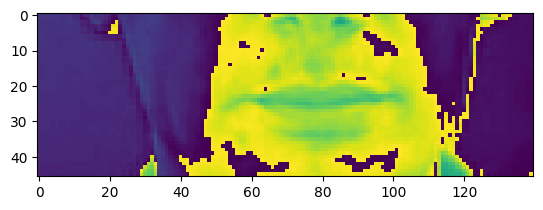

In [275]:
plt.imshow(frames[70]);
# showing lips from the videos

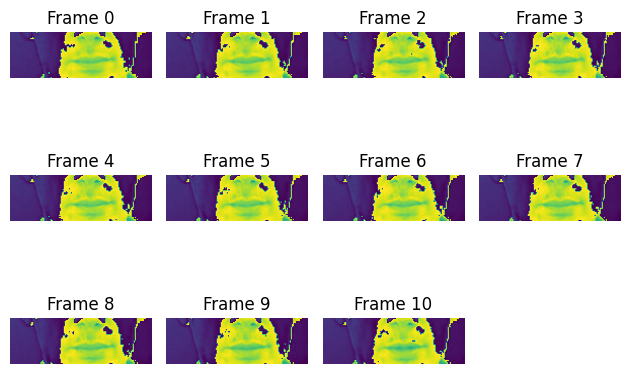

In [276]:
# Plot frames from 0 to 10
for i in range(11):  # Range from 0 to 10 (inclusive)
    plt.subplot(3, 4, i+1)  # Creating a 3x4 grid of subplots, adjust the dimensions as needed
    plt.imshow(frames[i])
    plt.title(f'Frame {i}')
    plt.axis('off')  # Turn off the axis labels

plt.tight_layout()  # Adjust spacing between subplots if needed
plt.show()

# this frame is showing different lips

In [277]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14,  0,  2, 12, 21,  5,  0,  1, 20,  0,  6,  0, 20, 23, 15,
        0, 14, 15, 23])>

In [278]:
num_to_char(alignments)

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'b', b'i', b'n', b'', b'b', b'l', b'u', b'e', b'', b'a', b't',
       b'', b'f', b'', b't', b'w', b'o', b'', b'n', b'o', b'w'],
      dtype=object)>

In [279]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', '', 'b', 'l', 'u', 'e', '', 'a', 't', '', 'f', '', 't', 'w', 'o', '', 'n', 'o', 'w']


In [280]:
# tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

In [281]:
import nltk

# Download the necessary resources (only required for the first time)
nltk.download('punkt')

aligned_string = tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

aligned_string_str = aligned_string.numpy().decode()

words = nltk.word_tokenize(aligned_string_str)

for word in words:
    print(word)


binblueatftwonow


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [282]:
# mapple function
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result



The mapple_function passes the path argument to the load_data function using tf.py_function, which wraps the load_data function and ensures it can be executed within TensorFlow's graph. It specifies that the expected output types are tf.float32 and tf.float64.

The result of tf.py_function is stored in the result variable and then returned as the output of the mapple_function. Since the result is returned as a list of strings (List[str]), it suggests that the load_data function may convert the processed data into string format before returning it.

To fully understand the functionality of this code, you would need to examine the implementation of the load_data function and any related functions or modules it depends on.







# Create Data Pipeline

In [283]:
data = tf.data.Dataset.list_files('./drive/MyDrive/data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [284]:
frames, alignments = data.as_numpy_iterator().next()

In [285]:
frames

array([[[[[ 1.4654757 ],
          [ 1.4654757 ],
          [ 1.4654757 ],
          ...,
          [ 0.        ],
          [ 0.03960745],
          [ 0.03960745]],

         [[ 1.4654757 ],
          [ 1.4654757 ],
          [ 1.4654757 ],
          ...,
          [ 0.        ],
          [ 0.03960745],
          [ 0.03960745]],

         [[ 1.3862609 ],
          [ 1.3862609 ],
          [ 1.3862609 ],
          ...,
          [ 0.11882236],
          [ 0.0792149 ],
          [ 0.0792149 ]],

         ...,

         [[ 0.9901863 ],
          [ 0.9901863 ],
          [ 0.9901863 ],
          ...,
          [ 9.94147   ],
          [ 9.901863  ],
          [ 9.901863  ]],

         [[ 0.9901863 ],
          [ 0.9901863 ],
          [ 0.9901863 ],
          ...,
          [ 9.901863  ],
          [ 9.862255  ],
          [ 9.862255  ]],

         [[ 0.9901863 ],
          [ 0.9901863 ],
          [ 0.9901863 ],
          ...,
          [ 9.901863  ],
          [ 9.862255  ],
          

In [286]:
len(frames)

2

In [287]:
alignments

array([[12,  1, 25,  0,  7, 18,  5,  5, 14,  0,  9, 14,  0,  6,  0, 20,
        23, 15,  0, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  9, 14,  0,  7, 18,  5,  5, 14,  0,  9, 14,  0,  1,  0, 20,
         8, 18,  5,  5,  0, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [288]:
test = data.as_numpy_iterator()

In [289]:
test

In [290]:
val = test.next(); val[0]

array([[[[[ 1.3107471 ],
          [ 1.3107471 ],
          [ 1.3504667 ],
          ...,
          [ 0.11915883],
          [ 0.15887843],
          [ 0.15887843]],

         [[ 1.3107471 ],
          [ 1.3107471 ],
          [ 1.3504667 ],
          ...,
          [ 0.11915883],
          [ 0.15887843],
          [ 0.15887843]],

         [[ 1.4299059 ],
          [ 1.4299059 ],
          [ 1.4299059 ],
          ...,
          [ 0.19859804],
          [ 0.11915883],
          [ 0.11915883]],

         ...,

         [[ 0.91355103],
          [ 0.91355103],
          [ 0.91355103],
          ...,
          [10.049061  ],
          [10.049061  ],
          [10.049061  ]],

         [[ 0.91355103],
          [ 0.91355103],
          [ 0.91355103],
          ...,
          [10.049061  ],
          [10.049061  ],
          [10.049061  ]],

         [[ 0.91355103],
          [ 0.91355103],
          [ 0.91355103],
          ...,
          [10.049061  ],
          [10.049061  ],
          

In [291]:
imageio.mimsave('./animate.gif', val[0][1], fps=10)

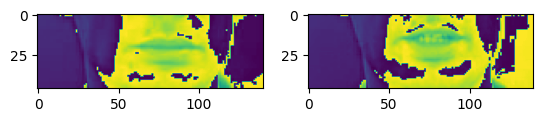

In [292]:
fig, axs = plt.subplots(1, 2)  # Create a figure with 1 row and 2 columns
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
axs[0].imshow(val[0][0][0])  # Display the first image in the first subplot
axs[1].imshow(val[0][1][50])  # Display the second image in the second subplot

plt.show()

In [293]:
tf.strings.reduce_join([num_to_char(word) + ' ' for word in val[1][0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'p l a c e  r e d  w i t h  j  n i n e  s o o n               '>